In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 3
NUM_THRESHOLD_POINTS = 500




In [2]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/non-hierarchical/L_SHIE/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
posterior

In [3]:
charges = sorted(df["compound_charge_params"].unique())     # Sort the encoded charges so they are in the same order as the posterior samples
charges = encoder_dict['compound_charge_params'].inverse_transform(charges)     # Then decode the charges, this maintains the order of the charges
charges


array(['20-0-80-25', '50-0-50-100'], dtype=object)

In [4]:
named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

for named_param, param in zip(named_params, params):
    print(named_param, param.shape)


a (4000, 8, 4, 2, 6)
b (4000, 8, 4, 2, 6)
L (4000, 8, 4, 2, 6)
ℓ (4000, 8, 4, 2, 6)
H (4000, 8, 4, 2, 6)


In [5]:
subjects = sorted(df['participant'].unique())
subjects = encoder_dict['participant'].inverse_transform(subjects)
subjects


array(['amap01', 'amap02', 'amap03', 'amap04', 'amap05', 'amap06',
       'amap07', 'amap08'], dtype=object)

In [6]:
positions = sorted(df['compound_position'].unique())
positions = encoder_dict['compound_position'].inverse_transform(positions)
positions


array(['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC'], dtype=object)

In [ ]:
def get_normalized_input_output(charge_ind):
    # charge_ind = 0
    norm_y = []
    norm_x = []

    for subject_ind, subject in enumerate(subjects):
        # Fix the subject index and charge index
        curr_params = [
            params[:, subject_ind, :, charge_ind, :, None] for params in params
        ]

        # Take nanmean across posterior samples
        temp = np.nanmean(curr_params[0], axis=0)
        # Take nanmedian across compound positions and muscles
        median_threshold = np.nanmedian(temp)

        x_temp = np.linspace(0.,  median_threshold * MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)
        x_temp = x_temp[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp,
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_y = np.array(norm_y)
    norm_y = ma.masked_invalid(norm_y)
    return norm_x, norm_y


In [8]:
charge_ind = 0
x, y = get_normalized_input_output(charge_ind=charge_ind)
print(x.shape, y.shape)


(8, 1, 1, 1, 500) (8, 4000, 4, 6, 500)


In [9]:
# Take the maximum curve value across positions and intensity values
num_masked = y.mask.any(axis=(2, -1)).sum()
y_max = ma.max(y, axis=(2, -1), keepdims=True)
assert num_masked == y_max.mask.sum()


In [10]:
# Normalize using the maximum value
num_masked = y.mask.sum()
y = ma.where(y_max, y / y_max, 0.)
assert num_masked == y.mask.sum()


In [11]:
p = ma.sum(y, axis=-2, keepdims=True)

num_masked = y.mask.sum()
p = ma.where(p, y / p, 1 / y.shape[-2])
assert num_masked == p.mask.sum()


In [12]:
num_masked = p.mask.sum()
plogp = ma.where(p, p * ma.log(p), 0.)
assert num_masked == plogp.mask.sum()


In [13]:
entropy = 1 + (plogp.sum(axis=-2) / np.log(y.shape[-2]))
entropy.shape


(8, 4000, 4, 500)

In [14]:
auc = np.trapz(y=entropy[...,:20], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)[:20], axis=-1)
auc.shape


(8, 4000, 4)

In [15]:
df.pulse_amplitude.max()

750

In [ ]:
330

7590

In [22]:
auc = auc.mean(axis=1)
auc.shape


(8, 4)

In [23]:
mat = auc[:, :, None] - auc[:, None, :]
mat.shape


(8, 4, 4)

In [24]:
test = stats.ttest_1samp(mat, popmean=0, axis=0)
pvalues = test.pvalue
pvalues.shape


(4, 4)

In [25]:
# verify order in heatmap
(auc[:, 0] - auc[:, 3]).mean()

-0.194106964185014

<Axes: >

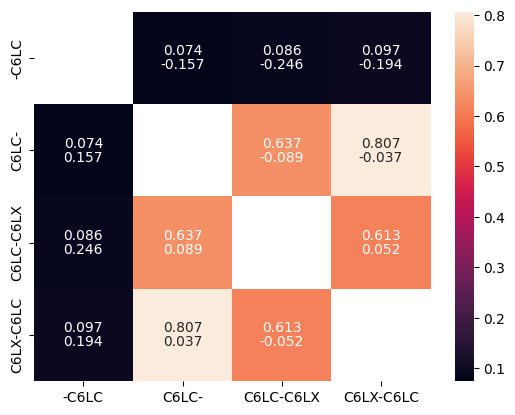

In [26]:
sns.heatmap(pvalues, xticklabels=positions, yticklabels=positions, annot=False)
sns.heatmap(pvalues, xticklabels=positions, yticklabels=positions, annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=positions, yticklabels=positions, annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)


In [27]:
# src = f"/home/andres/repos/rat-mapping-paper/notebooks/L_SHIE/selectivity_means.pkl"

# with open(src, "wb") as f:
#     pickle.dump([dashc , cdash, c_x, x_c], f)